## 1. Import des données

On s'intéresse maintenant à un problème bi-objectif ou les positions des offices sont des variables. Dans un premier temps, on veut optmiser les deux objectifs suivant: 
- distance totale
- workload des représentant

In [2]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Assignement initial des représnetant aux briques
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}

nbReps = 4
nbBlocks = 22

matrixInitAssignment = np.zeros((nbReps, nbBlocks), dtype=int)
for brique, rep in initial_assignment.items():
    matrixInitAssignment[rep - 1, brique - 1] = 1  # Ajustement 0-based

#Traitement du workload
workload_df = pd.read_csv("bricks_index_values.csv")
workload_df.drop(columns=["brick"], inplace=True)
workload_matrix = workload_df.to_numpy().T.flatten()  # shape (22,)

#Lecture du workload
dfWorkload = pd.read_csv("bricks_index_values.csv")
dfWorkload.drop(columns=["brick"], inplace=True)
arrayWorkloads = dfWorkload.to_numpy().T.flatten()  # shape (22,)

#Lecture des distances 
dfDistances = pd.read_excel("distances.xlsx", sheet_name="brick-brick", skiprows=1)

#Suppression éventuelle de colonnes inutiles
dfDistances = dfDistances.iloc[:, 2:]  #on garde seulement les colonnes distances
matrixDistances = dfDistances.to_numpy()  # shape (22,22)

# Accès facilité des center_bricks pour chaque représentant
dictInitialCenters = {1: 4, 2: 14, 3: 16, 4: 22}


## 2. Modèle bi-objectif

Dans cette cellule, nous allons définir la fonction `buildRelocationModel` qui crée et configure un **modèle Gurobi** :

- **Variables** :
  - `varAssign[rep, block]` (binaire) = 1 si la brique `block` est assignée au représentant `rep`.
  - `varCenter[rep, block]` (binaire) = 1 si la brique `block` est choisie comme “center/bureau” du représentant `rep`.
  - `varMaxLoad` (continue) = la charge de travail maximale parmi tous les représentants.

- **Fonction Objectif** :
  \[
    distance_totale + alpha * varMaxLoad
  \]
  où distance_totale est la somme des distances entre la brique bureau et les briques assignées.

- **Contraintes** :
  1. Chaque brique est affectée à un seul SR.
  2. Chaque SR choisit exactement 1 brique comme bureau.
  3. `varMaxLoad >= somme(workloads)` pour chaque SR.
  4. Calcul optionnel du nombre de bureaux relocalisés (`varNbRelocated`).

On renvoie le modèle et les variables pour manipulation ultérieure.


In [3]:
def buildRelocationModel(nbReps, nbBlocks, matrixDistances, arrayWorkloads, dictInitialCenters, alpha=0.05):
    """
    Paramètres :
    nbReps : int
        Nombre de représentants
    nbBlocks : int
        Nombre de briques
    matrixDistances : np.ndarray (nbBlocks x nbBlocks)
        Distances entre paires de briques
    arrayWorkloads : np.ndarray (nbBlocks, )
        Charge de travail de chaque brique (0-based)
    dictInitialCenters : dict
        Mapping SR -> brique center initial (notation 1-based)
    alpha : float
        Pondération de la charge max dans l'objectif
    """

    modelOpt = gp.Model("Relocation_Optimization")

    #Variables d'assignation
    varAssign = modelOpt.addVars(nbReps, nbBlocks, vtype=GRB.BINARY, name="Assign")

    #Variables de centre de bureau
    varCenter = modelOpt.addVars(nbReps, nbBlocks, vtype=GRB.BINARY, name="Center")

    #Variable continue pour la charge max
    varMaxLoad = modelOpt.addVar(name="MaxWorkload")

    # Calcul de la distance totale : sum_{rep,b,b'} matrixDistances[b', b] * varAssign[rep,b] * varCenter[rep,b']
    totalTravelDist = quicksum(
        matrixDistances[bureau, bloc] * varAssign[rep, bloc] * varCenter[rep, bureau]
        for rep in range(nbReps)
        for bloc in range(nbBlocks)
        for bureau in range(nbBlocks))

    #Objectif
    modelOpt.setObjective(totalTravelDist + alpha * varMaxLoad, GRB.MINIMIZE)

    #Contraintes
    for bloc in range(nbBlocks):
        modelOpt.addConstr(quicksum(varAssign[rep, bloc] for rep in range(nbReps)) == 1,name=f"OneRepPerBlock_{bloc}",)

    for rep in range(nbReps):
        modelOpt.addConstr(quicksum(varCenter[rep, bureau] for bureau in range(nbBlocks)) == 1,name=f"OneCenterPerRep_{rep}",)

    for rep in range(nbReps):
        modelOpt.addConstr(varMaxLoad>= quicksum(varAssign[rep, bloc] * arrayWorkloads[bloc] for bloc in range(nbBlocks)),name=f"MaxLoadRep_{rep}",)

    varNbRelocated = quicksum(1 - varCenter[rep, dictInitialCenters[rep + 1] - 1] for rep in range(nbReps))

    return modelOpt, varAssign, varCenter, totalTravelDist, varMaxLoad, varNbRelocated


## 3. Résolution via epsilon constraint

Ici, on applique la méthode epsilon constraint ou l’idée est de :

1. Résoudre une première fois le modèle.  
2. Tant qu’il reste **optimal**, ajouter une contrainte `varMaxLoad <= (valeur_courante - stepEpsilon)` pour forcer la recherche d’une nouvelle solution (ou déclarer l’insatisfaction).  
3. Collecter à chaque itération la distance totale, la charge max, et le nombre de bureaux relocalisés.  

On pourra ensuite tracer le **front de Pareto** Distance vs MaxWorkload.

In [4]:
def exploreParetoEpsilon(modelOpt,varAssign,varCenter,totalTravelDist,varMaxLoad,varNbRelocated,stepEpsilon):
    listeDistance = []
    listeMaxWork = []
    listeReloc = []

    modelOpt.Params.LogToConsole = 0
    modelOpt.optimize()

    while modelOpt.status == GRB.OPTIMAL:
        distActuelle = totalTravelDist.getValue()
        workloadActuel = varMaxLoad.X
        relocatedActuel = varNbRelocated.getValue()

        afficher_solution(modelOpt, varAssign, varCenter, totalTravelDist, varMaxLoad, varNbRelocated)

        #Stockage des résultats
        listeDistance.append(distActuelle)
        listeMaxWork.append(workloadActuel)
        listeReloc.append(relocatedActuel)

        #Ajout une contrainte plus stricte sur varMaxLoad
        newBound = workloadActuel - stepEpsilon
        modelOpt.addConstr(varMaxLoad <= newBound, name=f"EpsCon_{len(listeDistance)}")

        modelOpt.optimize()

    return listeDistance, listeMaxWork, listeReloc

In [5]:
def afficher_solution(modelOpt,varAssign,varCenter,totalTravelDist,varMaxLoad,varNbRelocated,matrixDistances=None,workloadArray=None,show_1_based=True,):

    sr_list = sorted(set(idx[0] for idx in varAssign.keys()))
    brick_list = sorted(set(idx[1] for idx in varAssign.keys()))

    dist_totale = totalTravelDist.getValue() if totalTravelDist is not None else None
    max_w = varMaxLoad.X if varMaxLoad is not None else None
    reloc = varNbRelocated.getValue() if varNbRelocated is not None else None
    obj_val = modelOpt.ObjVal

    print("\n===== SOLUTION COURANTE =====")

    for sr in sr_list:
        # Trouver la brique center
        center_blocks = [b for b in brick_list if varCenter[sr, b].X > 0.5]
        if len(center_blocks) == 1:
            center_b = center_blocks[0]
        else:
            center_b = None  # Cas improbable si le modèle est correct

        # Liste des briques assignées
        assigned_bricks = [b for b in brick_list if varAssign[sr, b].X > 0.5]

        # Calcul distance cumulée pour ce SR (si on a matrixDistances et un center)
        sr_distance = 0.0
        if matrixDistances is not None and center_b is not None:
            for b_assigned in assigned_bricks:
                sr_distance += matrixDistances[center_b, b_assigned]

        # Calcul de la charge cumulée pour ce SR (si on a workloadArray)
        sr_workload = 0.0
        if workloadArray is not None:
            for b_assigned in assigned_bricks:
                sr_workload += workloadArray[b_assigned]

        # Ajustement d'indices en 1-based si besoin
        if show_1_based:
            sr_disp = sr + 1
            center_disp = (center_b + 1) if center_b is not None else None
            assigned_disp = [b + 1 for b in assigned_bricks]
        else:
            sr_disp = sr
            center_disp = center_b
            assigned_disp = assigned_bricks

        # Affichage
        print(f"[SR {sr_disp}] ")
        print(f"  - Center : {center_disp}")
        print(f"  - Briques assignées : {assigned_disp}")
        if matrixDistances is not None:
            print(f"  - Distance cumulée : {sr_distance:.3f}")
        if workloadArray is not None:
            print(f"  - Workload cumulée : {sr_workload:.3f}")
        print("")

    print("===== INDICATEURS GLOBAUX =====")
    if dist_totale is not None:
        print(f" - Distance totale   : {dist_totale:.3f}")
    if max_w is not None:
        print(f" - Max workload      : {max_w:.3f}")
    if reloc is not None:
        print(f" - Bureaux relocalisés : {reloc:.0f}")
    print(f" - Valeur de l'objectif : {obj_val:.3f}")

    print("================================\n")


## 4. Plot des résultats

Set parameter Username
Set parameter LicenseID to value 2601683
Academic license - for non-commercial use only - expires 2025-12-18
Set parameter LogToConsole to value 0

===== SOLUTION COURANTE =====
[SR 1] 
  - Center : 2
  - Briques assignées : [1, 2, 3, 19, 20, 21, 22]

[SR 2] 
  - Center : 12
  - Briques assignées : [12]

[SR 3] 
  - Center : 6
  - Briques assignées : [4, 5, 6, 7, 8, 9]

[SR 4] 
  - Center : 15
  - Briques assignées : [10, 11, 13, 14, 15, 16, 17, 18]

===== INDICATEURS GLOBAUX =====
 - Distance totale   : 88.302
 - Max workload      : 2.160
 - Bureaux relocalisés : 4
 - Valeur de l'objectif : 88.323


===== SOLUTION COURANTE =====
[SR 1] 
  - Center : 2
  - Briques assignées : [1, 2, 3, 19, 20, 21, 22]

[SR 2] 
  - Center : 15
  - Briques assignées : [10, 11, 14, 15, 16, 17, 18]

[SR 3] 
  - Center : 6
  - Briques assignées : [4, 5, 6, 7, 8, 9, 13]

[SR 4] 
  - Center : 12
  - Briques assignées : [12]

===== INDICATEURS GLOBAUX =====
 - Distance totale   : 90.939


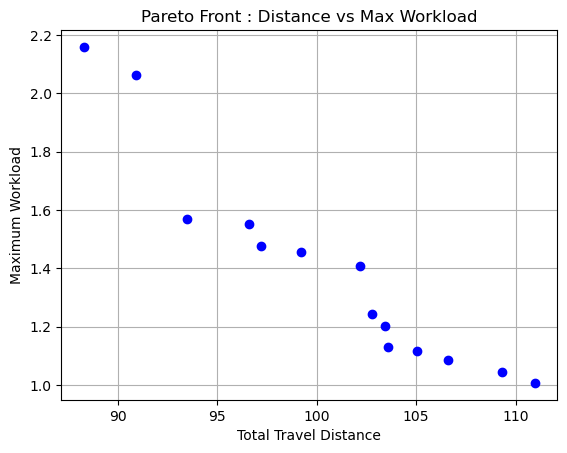

In [6]:
modelOptimization, varAssign, varCenter, exprTotalDist, exprMaxLoad, exprRelocCount = (buildRelocationModel(nbReps=nbReps,nbBlocks=nbBlocks,matrixDistances=matrixDistances,arrayWorkloads=arrayWorkloads,dictInitialCenters=dictInitialCenters,alpha=0.01,))

listDist, listWork, listReloc = exploreParetoEpsilon(modelOptimization,varAssign,varCenter,exprTotalDist,exprMaxLoad,exprRelocCount,stepEpsilon=0.01,)


# Créer le dossier plots s'il n'existe pas
if not os.path.exists('plots'):
    os.makedirs('plots')
    
plt.figure()
plt.plot(listDist, listWork, "o", color="blue")
plt.xlabel("Total Travel Distance")
plt.ylabel("Maximum Workload")
plt.title("Pareto Front : Distance vs Max Workload")
plt.grid(True)
plt.savefig("plots/step3_bi_objectif.png")
plt.show()

## 5. Three-objective problem (total distance,workload fairness, and number of relocated offices)

L'objectif de cette deuxième partie est de modéliser un modèle 3 objectifs sous la forme d'une weighted sum: 
- la distance totale (`exprDist`),
- la charge maximale (`varMaxLoad`),
- le nombre de bureaux relocalisés (`varNbRelocVar`)

Par rapport à la version précédente (bi-objectif distance + charge), nous avons **ajouté** un troisième objectif mesurant la **disruption** via le nombre de bureaux qui changent de place. 

Cela devient un **Weighted Sum** : 
\[
    distance + alpha * maxLoad + beta * nbReloc.
\]

- Nous définissons une **variable entière** `varNbRelocVar` pour le nombre de relocalisations, contrainte à être égale à la somme \(\sum_{s}[1 - c_{s,\text{centerInitial}}]\).  
- L'objectif comprend maintenant beta * nbRelocVar en plus de la distance et de la charge.  

### Variables et Contraintes

- `varAssign[s, b]` (binaire) : indique si la brique `b` est attribuée au SR `s`.  
- `varCenter[s, b]` (binaire) : indique si la brique `b` est choisie comme centre pour le SR `s`.  
- `varMaxLoad` (continue) : la charge de travail maximale d’un SR.  
- `varNbRelocVar` (entière) : nombre de bureaux relocalisés.  
- Contraintes standard : chaque brique est affectée à un seul SR, chaque SR a un seul centre, etc.

In [7]:
def buildThreeObjectiveModel(nbReps: int,nbBlocks: int,matrixDistances: np.ndarray,arrayWorkloads: np.ndarray,dictInitialCenters: dict,alpha: float = 0.05,beta: float = 0.05,):

    model3obj = gp.Model("ThreeObjective_Optimization")

    #Variables d'assignation, des centres et de la charge max
    varAssign = model3obj.addVars(nbReps, nbBlocks, vtype=GRB.BINARY, name="Assign")
    varCenter = model3obj.addVars(nbReps, nbBlocks, vtype=GRB.BINARY, name="Center")
    varMaxLoad = model3obj.addVar(name="MaxWorkload", vtype=GRB.CONTINUOUS)

    #Calcul de la distance totale
    exprDist = quicksum(
        matrixDistances[bC, bA] * varAssign[s, bA] * varCenter[s, bC]
        for s in range(nbReps)
        for bA in range(nbBlocks)
        for bC in range(nbBlocks)
    )

    #Calcul de l'expression du nb de relocalisations
    exprReloc = quicksum(1 - varCenter[s, dictInitialCenters[s + 1] - 1] for s in range(nbReps))

    #nbReloc = une variable ENTIER :
    varNbRelocVar = model3obj.addVar(name="NbRelocVar", vtype=GRB.INTEGER)
    #Contrainte : varNbRelocVar == exprReloc
    model3obj.addConstr(varNbRelocVar == exprReloc, name="defNbReloc")

    #Contraintes standard
    for b in range(nbBlocks):
        model3obj.addConstr(quicksum(varAssign[s, b] for s in range(nbReps)) == 1,name=f"OneRepPerBlock_{b}",)

    for s in range(nbReps):
        model3obj.addConstr(quicksum(varCenter[s, bC] for bC in range(nbBlocks)) == 1,name=f"OneCenterPerRep_{s}",)

    for s in range(nbReps):
        model3obj.addConstr(varMaxLoad>= quicksum(varAssign[s, b] * arrayWorkloads[b] for b in range(nbBlocks)),name=f"MaxLoadRep_{s}",)

    #Three Objectif Weighted Sum : dist + alpha*maxLoad + beta*varNbRelocVar
    model3obj.setObjective(exprDist + alpha * varMaxLoad + beta * varNbRelocVar, GRB.MINIMIZE)

    return model3obj, varAssign, varCenter, varMaxLoad, exprDist, varNbRelocVar


Nous redefinissons la fonction d'affichage adaptée au cas de figure afin d'accèder aux valeurs des variables. 
Pour la solution courante du modèle :

- Pour chaque SR : son “center brick”, la liste des briques assignées,
- La distance SR (si on passe la matrice de distances) et la charge SR (si on passe le workload),
- Les indicateurs globaux : distance totale, workload max, nb de relocalisations, objectif.

In [8]:
def afficher_solution_3objective(
    modelOpt,
    varAssign,
    varCenter,
    totalTravelDist,
    varMaxLoad,
    varNbRelocated,
    matrixDistances=None,
    workloadArray=None,
    show_1_based=True,
):
    sr_list = sorted(set(idx[0] for idx in varAssign.keys()))
    brick_list = sorted(set(idx[1] for idx in varAssign.keys()))

    dist_totale = totalTravelDist.getValue() if totalTravelDist is not None else None
    max_w = varMaxLoad.X if varMaxLoad is not None else None
    reloc = varNbRelocated.X if varNbRelocated is not None else None
    obj_val = modelOpt.ObjVal

    print("\n===== SOLUTION COURANTE =====")

    for sr in sr_list:
        # Trouver la brique center
        center_blocks = [b for b in brick_list if varCenter[sr, b].X > 0.5]
        if len(center_blocks) == 1:
            center_b = center_blocks[0]
        else:
            center_b = None  # Cas improbable si le modèle est correct

        # Liste des briques assignées
        assigned_bricks = [b for b in brick_list if varAssign[sr, b].X > 0.5]

        # Calcul distance cumulée pour ce SR (si on a matrixDistances et un center)
        sr_distance = 0.0
        if matrixDistances is not None and center_b is not None:
            for b_assigned in assigned_bricks:
                sr_distance += matrixDistances[center_b, b_assigned]

        # Calcul de la charge cumulée pour ce SR (si on a workloadArray)
        sr_workload = 0.0
        if workloadArray is not None:
            for b_assigned in assigned_bricks:
                sr_workload += workloadArray[b_assigned]

        # Ajustement d'indices en 1-based si besoin
        if show_1_based:
            sr_disp = sr + 1
            center_disp = (center_b + 1) if center_b is not None else None
            assigned_disp = [b + 1 for b in assigned_bricks]
        else:
            sr_disp = sr
            center_disp = center_b
            assigned_disp = assigned_bricks

        # Affichage
        print(f"[SR {sr_disp}] ")
        print(f"  - Center : {center_disp}")
        print(f"  - Briques assignées : {assigned_disp}")
        if matrixDistances is not None:
            print(f"  - Distance cumulée : {sr_distance:.3f}")
        if workloadArray is not None:
            print(f"  - Workload cumulée : {sr_workload:.3f}")
        print("")

    print("===== INDICATEURS GLOBAUX =====")
    if dist_totale is not None:
        print(f" - Distance totale   : {dist_totale:.3f}")
    if max_w is not None:
        print(f" - Max workload      : {max_w:.3f}")
    if reloc is not None:
        print(f" - Bureaux relocalisés : {reloc:.0f}")
    print(f" - Valeur de l'objectif : {obj_val:.3f}")

    print("================================\n")


Ici, nous appliquons le nouveau schéma \(\epsilon\)-constraint sur `varMaxLoad`. 
À chaque solution optimale trouvée, nous :

1. Affichons la solution (console) via `afficher_solution_3objective`,
2. Ajoutons la contrainte `varMaxLoad <= (valeur_courante - stepEpsilon)`,
3. Relançons l’optimisation.

On stocke la distance, la charge, et le nb de relocalisations dans trois listes.


In [9]:
def exploreParetoEpsilon_3obj_with_print(model3obj,varAssign,varCenter,totalTravelDist,varMaxLoad,varNbRelocVar,stepEpsilon=0.01,matrixDistances=None,workloadArray=None,):

    listDist = []
    listWork = []
    listReloc = []

    model3obj.Params.LogToConsole = 0
    model3obj.optimize()

    sol_count = 0
    while model3obj.status == GRB.OPTIMAL:
        sol_count += 1

        # Récupère les valeurs courantes
        dist_val = totalTravelDist.getValue()
        work_val = varMaxLoad.X
        reloc_val = varNbRelocVar.X

        # --- Affiche la solution en console ---
        print(f"\n=== EPSILON-CONSTRAINT : SOLUTION #{sol_count} ===")
        afficher_solution_3objective(modelOpt=model3obj,varAssign=varAssign,varCenter=varCenter,totalTravelDist=totalTravelDist,varMaxLoad=varMaxLoad,varNbRelocated=varNbRelocVar,matrixDistances=matrixDistances,workloadArray=workloadArray,show_1_based=True,)

        # Stocke dans les listes
        listDist.append(dist_val)
        listWork.append(work_val)
        listReloc.append(reloc_val)

        #Ajout de la contrainte varMaxLoad <= (valeur courante - stepEpsilon)
        newBound = work_val - stepEpsilon
        model3obj.addConstr(varMaxLoad <= newBound, name=f"eps_{sol_count}")
        model3obj.optimize()

    print("\nAucune nouvelle solution optimale, fin du schéma epsilon.\n")
    return listDist, listWork, listReloc


Enfin, nous proposons une fonction pour tracer en 3D le triplet (distance, workload, reloc). 
Nous arrondissons la valeur de `reloc` et imposons 5 ticks (0..4) sur la barre de couleurs.

In [10]:
import matplotlib.colors as mcolors


def plot_3d_solutions_discrete(list_solutions):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    distVals = [sol["dist"] for sol in list_solutions]
    workVals = [sol["work"] for sol in list_solutions]
    # On arrondit reloc et on limite au range [0..4]
    relocVals = [int(round(sol["reloc"])) for sol in list_solutions]

    # Définition d'un "discrete colormap" : 5 couleurs pour 0..4
    # (vous pouvez en mettre autant que vous voulez)
    colors = ["blue", "green", "yellow", "orange", "red"]
    discrete_cmap = mcolors.ListedColormap(colors)

    # bounds = les "limites" entre catégories
    bounds = [0, 1, 2, 3, 4, 5]  # => 6 bornes pour 5 intervalles
    norm = mcolors.BoundaryNorm(bounds, discrete_cmap.N)

    sc = ax.scatter(
        distVals, workVals, relocVals, c=relocVals, cmap=discrete_cmap, norm=norm, s=50
    )

    ax.set_xlabel("Distance Totale")
    ax.set_ylabel("Max Workload")
    ax.set_zlabel("Nb Relocated")

    # Barre de couleurs discrète : ticks = [0,1,2,3,4]
    cb = fig.colorbar(sc, spacing="proportional", ticks=[0, 1, 2, 3, 4])
    cb.set_label("Nb Reloc (couleurs discrètes)")

    # Créer le dossier plots s'il n'existe pas
    if not os.path.exists("plots"):
        os.makedirs("plots")
        
    plt.title("Solutions 3D : (Dist, Work, Reloc)")
    plt.savefig("plots/step3_three_objectif.png")
    plt.show()


Set parameter LogToConsole to value 0



=== EPSILON-CONSTRAINT : SOLUTION #1 ===

===== SOLUTION COURANTE =====
[SR 1] 
  - Center : 6
  - Briques assignées : [4, 5, 6, 7, 8, 9]
  - Distance cumulée : 13.280
  - Workload cumulée : 0.751

[SR 2] 
  - Center : 12
  - Briques assignées : [12]
  - Distance cumulée : 0.000
  - Workload cumulée : 0.083

[SR 3] 
  - Center : 15
  - Briques assignées : [10, 11, 13, 14, 15, 16, 17, 18]
  - Distance cumulée : 18.175
  - Workload cumulée : 2.160

[SR 4] 
  - Center : 2
  - Briques assignées : [1, 2, 3, 19, 20, 21, 22]
  - Distance cumulée : 56.847
  - Workload cumulée : 1.007

===== INDICATEURS GLOBAUX =====
 - Distance totale   : 88.302
 - Max workload      : 2.160
 - Bureaux relocalisés : 4
 - Valeur de l'objectif : 88.610


=== EPSILON-CONSTRAINT : SOLUTION #2 ===

===== SOLUTION COURANTE =====
[SR 1] 
  - Center : 6
  - Briques assignées : [4, 5, 6, 7, 8, 9, 13]
  - Distance cumulée : 21.262
  - Workload cumulée : 0.848

[SR 2] 
  - Center : 12
  - Briques assignées : [12]
  - Dis

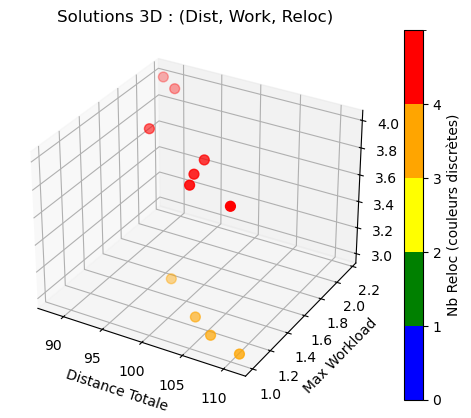

In [11]:
model3obj, varAssign, varCenter, varMaxLoad, exprDist, varNbRelocVar = buildThreeObjectiveModel(nbReps=nbReps,nbBlocks=nbBlocks,matrixDistances=matrixDistances,arrayWorkloads=arrayWorkloads,dictInitialCenters=dictInitialCenters,alpha=0.05,beta=0.05)

dist_list, work_list, reloc_list = exploreParetoEpsilon_3obj_with_print(model3obj,varAssign,varCenter,exprDist,varMaxLoad,varNbRelocVar,stepEpsilon=0.02,matrixDistances=matrixDistances,workloadArray=arrayWorkloads)

# Plot 3D
plot_3d_solutions_discrete(list_solutions)
list_solutions = [{'dist': dist, 'work': work, 'reloc': reloc} for dist, work, reloc in zip(dist_list, work_list, reloc_list)]
